<a href="https://colab.research.google.com/github/mrshamshir/2DHelicopterGame/blob/master/Lung_Tumor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install celluloid

In [39]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from tqdm.notebook import tqdm
import cv2

In [3]:
import tarfile
my_tar = tarfile.open('/content/drive/MyDrive/Copy of Task06_Lung.tar')
my_tar.extractall('./my_folder') # specify which folder to extract to
my_tar.close()

In [4]:
# Inspect some sample data
root = Path("/content/my_folder/Task06_Lung/imagesTr")
label = Path("/content/my_folder/Task06_Lung/labelsTr/")

In [5]:
# Load a sample NIfTI and its corresponding label mask

def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories whithin the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object


In [15]:
sample_path = list(root.glob("lung*"))[1]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

In [16]:
sample_path, sample_path_label

(PosixPath('/content/my_folder/Task06_Lung/imagesTr/lung_057.nii.gz'),
 PosixPath('/content/my_folder/Task06_Lung/labelsTr/lung_057.nii.gz'))

In [17]:
# Load NIfTI and extract image data
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata()

In [18]:
print(mask.shape)

(512, 512, 112)


In [19]:
# Find out the orientation
nib.aff2axcodes(data.affine)

('L', 'A', 'S')

In [20]:
# Inspect the loaded data with overlaid Ground Truth tumor segmentation using axial view
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, ct.shape[2], 2):  # axial view
    plt.imshow(ct[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    #plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




<IPython.core.display.Javascript object>

In [21]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video


## Preprocessing

1. CT images have a fixed range from -1000 to 3071. **Thus we can normalize by dividing by 3071**
2. As we want to focus on lung tumors, we can crop away parts of the lower abdomen to reduce the complexity and help the network learn. As an example, we might skip the first 30 slices (from lower abdomen to the neck) (last axis)
3. As we want to tackle this task on a slice level (2D) and not on a subject level (3D) to reduce the computational cost we should store the preprocessed data as 2d files, because reading a single slice is much faster than loading the complete NIfTI file.
4. Resize the single slices and masks to (256, 256) (when resizing the mask, pass interpolation=cv2.INTER_NEAREST to the resize function to apply nearest neighbour interpolation)

Loop over all_files and apply the preprocessing steps. <br />

In the preprocessing loop, we need to create a directory for each subject containg the ct and label slices with identical names. <br />
E.g:
* 0/data/0.npy
* 0/masks/0.npy

we will store the last 6 subjects as validation data


In [22]:
all_files = list(root.glob("lung_*"))  # Get all subjects

In [23]:
len(all_files)

63

In [24]:
save_root = Path("/content/my_folder/Task06_Lung/Preprocessed")

for counter, path_to_ct_data in enumerate(tqdm(all_files)):

    path_to_label = change_img_to_label_path(path_to_ct_data)  # Get path to ground truth

    # Load and extract corresponding data
    ct_data = nib.load(path_to_ct_data).get_fdata()
    label_data = nib.load(path_to_label).get_fdata()

    # Crop volume and label. Remove the first 30 slices
    ct_data = ct_data[:,:,30:] / 3071
    label_data = label_data[:,:,30:]

    # Check if train or val data and create corresponding path
    if counter < 57:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)

    # Loop over the slices in the full volume and store the data and labels in the data/masks directory
    for i in range(ct_data.shape[-1]):
        slice = ct_data[:,:,i]
        mask = label_data[:,:,i]

        # Resize slice and label to common resolution to reduce training time
        slice = cv2.resize(slice, (256, 256))
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)

        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)




  0%|          | 0/63 [00:00<?, ?it/s]

## Validate preprocessed data
Take a look at our stored files and inspect if everything worked as expected

In [47]:
path = Path("/content/my_folder/Task06_Lung/Preprocessed/train/10")  # Select a subject. Check the folder if it exists


In [48]:
list(path.glob("*"))

[PosixPath('/content/my_folder/Task06_Lung/Preprocessed/train/10/data'),
 PosixPath('/content/my_folder/Task06_Lung/Preprocessed/train/10/masks')]

In [101]:
1# Choose a file and load slice + mask

file = "143.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)
print(mask.any())

True


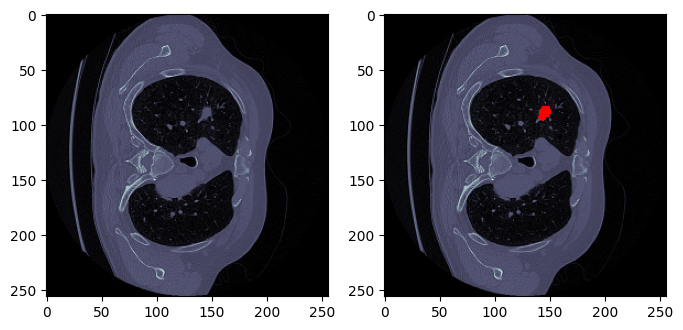

In [102]:
# Plot everything
# with gpu
#%matplotlib notebook
# with cpu
%matplotlib inline
fig, axis = plt.subplots(1, 2, figsize=(8, 8))
axis[0].imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
axis[1].imshow(slice, cmap="bone")
axis[1].imshow(mask_, cmap="autumn")


In [103]:
print(slice.min(), slice.max())

-0.33344187561055033 0.6308205796157603


In [ ]:
!cp -r /content/my_folder/Task06_Lung/Preprocessed /content/drive/MyDrive/Data

## Train

In [104]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.0/727.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 9.5 MB/s eta 0:00:00


In [105]:
!pip uninstall imgaug
!pip install imgaug

Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/imgaug-0.4.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/imgaug/*
Proceed (Y/n)? y
  Successfully uninstalled imgaug-0.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 6.5 MB/s eta 0:00:00


In [ ]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from celluloid import Camera
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

from dataset import LungDataset
from model import UNet

### Dataset Creation